[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SuperbTUM/ModelShare_Development/blob/master/notebooks/AutoML_dabl.ipynb)

In [1]:
!pip install aimodelshare --upgrade -q

     |████████████████████████████████| 951 kB 7.7 MB/s 
     |████████████████████████████████| 96 kB 1.5 MB/s 
     |████████████████████████████████| 442 kB 39.8 MB/s 
     |████████████████████████████████| 132 kB 35.5 MB/s 
     |████████████████████████████████| 22.3 MB 1.6 MB/s 
     |████████████████████████████████| 288 kB 47.2 MB/s 
     |████████████████████████████████| 8.6 MB 37.4 MB/s 
     |████████████████████████████████| 83 kB 1.8 MB/s 
     |████████████████████████████████| 146 kB 58.0 MB/s 
     |████████████████████████████████| 13.1 MB 39.1 MB/s 
     |████████████████████████████████| 178 kB 51.5 MB/s 
     |████████████████████████████████| 308 kB 51.8 MB/s 
     |████████████████████████████████| 291 kB 51.8 MB/s 
     |████████████████████████████████| 4.5 MB 44.4 MB/s 
     |████████████████████████████████| 79 kB 6.0 MB/s 
     |████████████████████████████████| 140 kB 59.9 MB/s 
     |████████████████████████████████| 55 kB 2.8 MB/s 
     |████████████████

In [2]:
import aimodelshare as ai

In [3]:
from aimodelshare.aws import set_credentials
set_credentials(credential_file="credentials.txt", type="deploy_model")

AI Model Share login credentials set successfully.
AWS credentials set successfully.


Two ways to obtain dataset; one is import_quickstart_data, another is to load csv file.

In [6]:
X_train, X_test, y_train_labels, y_test_labels, example_data = ai.import_quickstart_data("covid_tweets")
# Each sample is a sentence
print(y_train_labels[0])


Data downloaded successfully.

Preparing downloaded files for use...

Success! Your Quick Start materials have been downloaded. 
You are now ready to run the tutorial.
fake


In [5]:
!pip install dabl
import dabl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 558 kB 5.6 MB/s 


AutoML with Simple Classifier

In [13]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_simple = tf_idf_vectorizer.fit(X_train)

def preprocessor(data):
  from sklearn.feature_extraction.text import TfidfVectorizer
  tf1_new = TfidfVectorizer(vocabulary = tfidf_simple.vocabulary_)
  new_tfidf_df = tf1_new.fit_transform(data)
  new_tfidf_df = new_tfidf_df.todense()
  return new_tfidf_df

X_train_processed = preprocessor(X_train)
X_test_processed = preprocessor(X_test)
y_train_labels_processed = np.asarray(list(map(lambda x: 0 if x == "fake" else 1, y_train_labels))).reshape(len(X_train), 1)
y_test_labels_processed = np.asarray(list(map(lambda x: 0 if x == "fake" else 1, y_test_labels)))

print(X_train_processed.shape)
print(y_train_labels_processed.shape)
print(np.concatenate((X_train_processed, y_train_labels_processed), axis=1).shape)

pd_tweets = pd.DataFrame(np.concatenate((X_train_processed, y_train_labels_processed), axis=1), columns=["feature_" + str(i) for i in range(X_train_processed.shape[1])] + ["classification"])
ec = dabl.SimpleClassifier(random_state=0).fit(pd_tweets, target_col="classification")


(6505, 18039)
(6505, 1)
(6505, 18040)
Running DummyClassifier()
accuracy: 0.525 average_precision: 0.475 roc_auc: 0.500 recall_macro: 0.500 f1_macro: 0.344
=== new best DummyClassifier() (using recall_macro):
accuracy: 0.525 average_precision: 0.475 roc_auc: 0.500 recall_macro: 0.500 f1_macro: 0.344

Running GaussianNB()
accuracy: 0.722 average_precision: 0.846 roc_auc: 0.862 recall_macro: 0.731 f1_macro: 0.715
=== new best GaussianNB() (using recall_macro):
accuracy: 0.722 average_precision: 0.846 roc_auc: 0.862 recall_macro: 0.731 f1_macro: 0.715

Running MultinomialNB()
accuracy: 0.752 average_precision: 0.822 roc_auc: 0.864 recall_macro: 0.750 f1_macro: 0.750
=== new best MultinomialNB() (using recall_macro):
accuracy: 0.752 average_precision: 0.822 roc_auc: 0.864 recall_macro: 0.750 f1_macro: 0.750

Running DecisionTreeClassifier(class_weight='balanced', max_depth=1)
accuracy: 0.689 average_precision: 0.607 roc_auc: 0.689 recall_macro: 0.689 f1_macro: 0.689
Running DecisionTreeCla

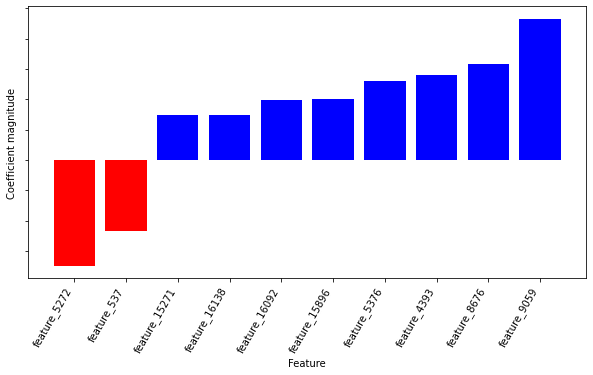

In [14]:
dabl.explain(ec)

In [16]:
ec.score(X_test_processed, y_test_labels_processed)

0.8092457420924575

AutoML with [params grid search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingGridSearchCV.html)

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv # experimental
from sklearn.model_selection import HalvingGridSearchCV

parameters = {"max_depth": [3, 5, 10], "min_samples_split": [2, 5, 10]}
base_estimator = RandomForestClassifier(random_state=0)
sh = HalvingGridSearchCV(base_estimator,
              parameters,
              cv=5,
              factor=2,
              resource="n_estimators",
              max_resources=30,
              aggressive_elimination=False,
              random_state=0).fit(X_train_processed, y_train_labels_processed.ravel())

sh.best_estimator_

RandomForestClassifier(max_depth=10, min_samples_split=10, n_estimators=24,
                       random_state=0)

In [23]:
best_estimator = sh.best_estimator_
best_estimator.score(X_test_processed, y_test_labels_processed)

0.8525547445255475